In [0]:
#Importing all the required libraries
#Pandas is used for reading the dataset
import pandas as pd

#NumPy is used for importing and manipulating of data
import numpy as np

#Matplotlib is used for plotting graphs
from matplotlib import pyplot as plt

#train_test_split is used for splitting the entire dataset into training and testing
from sklearn.model_selection import train_test_split

In [3]:
dataset = pd.read_csv('drive/My Drive/NLP Assignment 1/housing.csv')

#Data pre-processing i.e., remove all the NA entries
dataset = dataset.dropna()

print("Here are the first 10 rows of the dataset: ")

#To show the first 10 entries of the dataset use the dataset.head()
dataset.head(10)

Here are the first 10 rows of the dataset: 


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


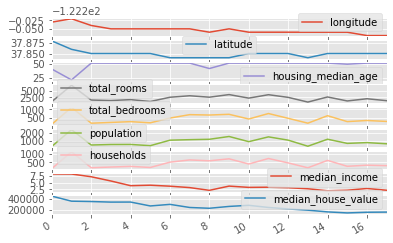

In [4]:
plt.style.use("ggplot")

#The following line is used for plotting 
#the sub-plots of first 18 samples from the dataset
dataset.head(18).plot(subplots=True)

#To save the plot that is obtained
#in good quality
plt.savefig('drive/My Drive/NLP Assignment 1/Subplot.png', format='png', dpi=1200)

In [0]:
#The output variable
Y = dataset['median_house_value']

#The training attributes
X = dataset.loc[:,'longitude':'median_income']

In [0]:
#Defining the training and testing split along-with the random state
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 2003)

#Converting into NumPy arrays
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
#Importing all the required libraries for our model
import torch
from torch.nn import Conv1d
from torch.nn import AvgPool1d
from torch.nn import MaxPool1d
from torch.nn import Dropout
from torch.nn import BatchNorm1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
#Model definintion
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    #Defining the superclass to store the parameters
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    self.batch_normalization = BatchNorm1d(inputs)

    #Defining the input layer
    self.input_layer = Conv1d(inputs, batch_size, kernel_size=1)
    
    self.avg_pooling_layer = AvgPool1d(1)
    
    self.avg_pooling_layer_2 = AvgPool1d(1)

    self.conv_layer = Conv1d(batch_size, 256, 1)

    self.flatten_layer = Flatten()

    self.linear_layer = Linear(256, 128)

    self.linear_layer_2 = Linear(128, 64)

    self.linear_layer_3 = Linear(64, 32)

    self.output_layer = Linear(32, outputs)
  
  #Defining methods to feed the input through the model
  def feed(self, input):
    
    #Reshape the entry so that it can be put in the input layer
    #Even though we are using 1D convolution, it is still expecting a 3D arrary
    #to process in a 1D fashion
    input = input.reshape((self.batch_size, self.inputs, 1))

    output = self.batch_normalization(input)

    #Getting the output of the first layer and run it through ReLU activation
    #function
    output = relu(self.input_layer(output))

    output = self.avg_pooling_layer(output)

    output = self.avg_pooling_layer_2(output)

    output = relu(self.conv_layer(output))

    output = self.flatten_layer(output)                          

    output = self.linear_layer(output)

    output = self.linear_layer_2(output)

    output = self.linear_layer_3(output)

    output = self.output_layer(output)

    return output

In [9]:
#Importing all the required libraries
from torch.optim import Adam

from torch.nn import L1Loss
from torch.nn import MSELoss

!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 4.9MB/s 


In [10]:
#Defining our batch size
batch_size = 512

#Pass the batch size, X columns, and Y columns 
model = CnnRegressor(batch_size, X.shape[1], 1)

#Used for setting the model to use the GPU for processing
#It also outputs our model summary
model.cuda()

CnnRegressor(
  (batch_normalization): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_layer): Conv1d(8, 512, kernel_size=(1,), stride=(1,))
  (avg_pooling_layer): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  (avg_pooling_layer_2): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  (conv_layer): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=256, out_features=128, bias=True)
  (linear_layer_2): Linear(in_features=128, out_features=64, bias=True)
  (linear_layer_3): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [0]:
#Will return the average L1Loss and R2Score of the passed model on the passed
#dataloader 
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  mselossperformance = MSELoss()
  score_metric = R2Score()

  avg_loss = 0
  avg_mseloss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):
    predictions = model.feed(input)

    loss = performance(predictions, output)
    mseloss = mselossperformance(predictions, output)

    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    avg_loss += loss.item()
    avg_mseloss += mseloss.item()
    avg_score += score
    count += 1

  return avg_loss / count, avg_mseloss / count, avg_score / count

In [12]:
#Training the model
epochs = 100

optimizer = Adam(model.parameters(), lr = 0.005)

#Convert the training set into torch variables for our model using the GPU
#as floats. The reshape is to remove a warning pytorch outputs otherwise.
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

#Creating DataLoader instance
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

#Initializing three arrays for outputting the data on graph through the 
#matplotlib library
lossData = []
mselossData = []
R2ScoreData = []
epochData = []

#Starting the training loop
for epoch in range(epochs):
  avg_loss, avg_mseloss, avg_r2_score = model_loss(model, loader, train = True, optimizer = optimizer)

  print("Epoch " + str(epoch + 1) + ":\n\tMSELoss = " + str(avg_mseloss) + "\n\tL1Loss = " + str(avg_loss) + "\n\tR^2Score = " + str(avg_r2_score))

  epochData.append(epoch + 1)
  lossData.append(avg_loss)
  mselossData.append(avg_mseloss)
  R2ScoreData.append(avg_r2_score)

Epoch 1:
	MSELoss = 45160436394.666664
	L1Loss = 176115.8052662037
	R^2Score = -3.0571457192848714
Epoch 2:
	MSELoss = 11789784291.555555
	L1Loss = 76931.77271412036
	R^2Score = -0.12068421508924852
Epoch 3:
	MSELoss = 6897909399.703704
	L1Loss = 57628.6634837963
	R^2Score = 0.4207589744951857
Epoch 4:
	MSELoss = 5389517767.111111
	L1Loss = 50911.95037615741
	R^2Score = 0.57869923193811
Epoch 5:
	MSELoss = 4846229257.481482
	L1Loss = 47835.4447337963
	R^2Score = 0.6281725261659943
Epoch 6:
	MSELoss = 4743756269.037037
	L1Loss = 47486.999710648146
	R^2Score = 0.637476827350437
Epoch 7:
	MSELoss = 4446152078.222222
	L1Loss = 45647.63512731482
	R^2Score = 0.6728063572364801
Epoch 8:
	MSELoss = 4406492804.740741
	L1Loss = 45519.55295138889
	R^2Score = 0.6806842963463671
Epoch 9:
	MSELoss = 4326027643.259259
	L1Loss = 45155.38917824074
	R^2Score = 0.676420276579976
Epoch 10:
	MSELoss = 4222214608.5925927
	L1Loss = 44463.02589699074
	R^2Score = 0.6793049711619916
Epoch 11:
	MSELoss = 4236956

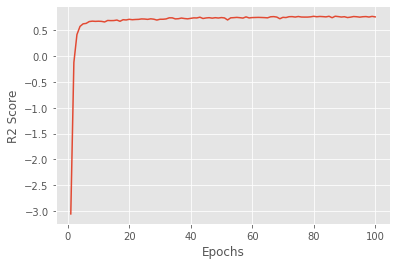

In [13]:
#Plotting epochs vs r2 score
plt.plot(epochData, R2ScoreData)

#Defining the y-axis
plt.ylabel('R2 Score')

#Defining the x-axis
plt.xlabel('Epochs')

#Used tho plot the graph
plt.show()

In [14]:
#Converting testing variables as torch variables for our model using the GPU
#as floats
inputs = torch.from_numpy(x_test_np).cuda().float() 
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

#Creating DataLoader instance
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

#Output the model's performance
avg_loss, avg_mseloss, avg_r2_score = model_loss(model, loader)

print("The model's L1 loss is: " + str(avg_loss)) 
print("The model's MSE loss is: " + str(avg_mseloss)) 
print("The model's R^2 score is: " + str(avg_r2_score))

The model's L1 loss is: 39216.05078125
The model's MSE loss is: 3185676381.090909
The model's R^2 score is: 0.7625395536493422


In [0]:
#Saving model
model_save_name = '0889445_1dconv_reg.pt'
path = "drive/My Drive/NLP Assignment 1/0889445_1dconv_reg" 
torch.save(model.state_dict(), path)